<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/Decision_Tree%EF%BC%88Python%E5%AE%9E%E7%8E%B0%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.熵的实现

In [12]:
from math import log
def calcShannonEnt(dataSet):
    '''
    计算香农熵
    :param dataSet:数据集
    :return: 计算结果
    '''
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: # 遍历每个实例，统计标签的频数
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): 
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob,2) # 以2为底的对数
    return shannonEnt

2.条件熵（conditional entropy）

In [15]:
def splitDataSet(dataSet, axis, value):
    '''
    按照给定特征划分数据集
    :param dataSet:待划分的数据集
    :param axis:划分数据集的特征
    :param value: 需要返回的特征的值
    :return: 划分结果列表
    '''
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]     #chop out axis used for splitting
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

def calcConditionalEntropy(dataSet, i, featList, uniqueVals):
    '''
    计算X_i给定的条件下，Y的条件熵
    :param dataSet:数据集
    :param i:维度i
    :param featList: 数据集特征列表
    :param uniqueVals: 数据集特征集合
    :return: 条件熵
    '''
    conditionEnt = 0.0
    for value in uniqueVals:
        subDataSet = splitDataSet(dataSet, i, value)
        prob = len(subDataSet) / float(len(dataSet))  # 极大似然估计概率
        conditionEnt += prob * calcShannonEnt(subDataSet)  # 条件熵的计算
    return conditionEnt

3.信息增益（information gain）


In [16]:
def calcInformationGain(dataSet, baseEntropy, i):
    '''
    计算信息增益
    :param dataSet:数据集
    :param baseEntropy:数据集的信息熵
    :param i: 特征维度i
    :return: 特征i对数据集的信息增益g(D|X_i)
    '''
    featList = [example[i] for example in dataSet]  # 第i维特征列表
    uniqueVals = set(featList)  # 转换成集合
    newEntropy = calcConditionalEntropy(dataSet, i, featList, uniqueVals)
    infoGain = baseEntropy - newEntropy  # 信息增益，就yes熵的减少，也就yes不确定性的减少
    return infoGain

4.信息增益比（information gain ratio）


In [17]:
def calcInformationGainRatio(dataSet, baseEntropy, i):
    '''
    计算信息增益比
    :param dataSet:数据集
    :param baseEntropy:数据集的信息熵
    :param i: 特征维度i
    :return: 特征i对数据集的信息增益比gR(D|X_i)
    '''
    return calcInformationGain(dataSet, baseEntropy, i) / baseEntropy


三、决策树的生成

In [18]:
def chooseBestFeatureToSplitByID3(dataSet):
    '''
            选择最好的数据集划分方式
    :param dataSet:数据集
    :return: 划分结果
    '''
    numFeatures = len(dataSet[0]) - 1  # 最后一列yes分类标签，不属于特征向量
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):  # 遍历所有特征
        infoGain = calcInformationGain(dataSet, baseEntropy, i)     # 计算信息增益
        if (infoGain > bestInfoGain):  # 选择最大的信息增益
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature  # 返回最优特征对应的维度

def majorityCnt(classList):
    '''
    采用多数表决的方法决定叶结点的分类
    :param: 所有的类标签列表
    :return: 出现次数最多的类
    '''
    classCount={}
    for vote in classList:                  # 统计所有类标签的频数
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reverse=True) # 排序
    return sortedClassCount[0][0]

def createTree(dataSet,labels):
    '''
    创建决策树
    :param: dataSet:训练数据集
    :return: labels:所有的类标签
    '''
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList): 
        return classList[0]             # 第一个递归结束条件：所有的类标签完全相同
    if len(dataSet[0]) == 1:        
        return majorityCnt(classList)   # 第二个递归结束条件：用完了所有特征
    bestFeat = chooseBestFeatureToSplitByID3(dataSet)   # 最优划分特征
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}         # 使用字典类型储存树的信息
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       # 复制所有类标签，保证每次递归调用时不改变原始列表的内容
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree

2.可视化

In [19]:
import matplotlib.pyplot as plt
# 定义文本框和箭头格式
decisionNode = dict(boxstyle="round4", color='#3366FF')  # 定义判断结点形态
leafNode = dict(boxstyle="circle", color='#FF6633')  # 定义叶结点形态
arrow_args = dict(arrowstyle="<-", color='g')  # 定义箭头

#计算叶结点数
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':# 测试结点的数据类型是否为字典
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

# 计算树的深度
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':# 测试结点的数据类型是否为字典
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

# 绘制带箭头的注释
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )

# 在父子结点间填充文本信息  
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)  # 计算宽与高
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]      
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)  # 标记子结点属性值
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD # 减少y偏移
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

{'house?': {'yes': 'agree', 'no': {'working?': {'yes': 'agree', 'no': 'refuse'}}}}


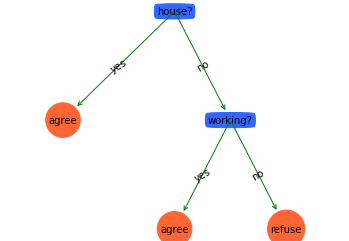

In [20]:
# 导入数据
def createDataSet():
    dataSet = [['youth', 'no', 'no', 1, 'refuse'],
               ['youth', 'no', 'no', '2', 'refuse'],
               ['youth', 'yes', 'no', '2', 'agree'],
               ['youth', 'yes', 'yes', 1, 'agree'],
               ['youth', 'no', 'no', 1, 'refuse'],
               ['mid', 'no', 'no', 1, 'refuse'],
               ['mid', 'no', 'no', '2', 'refuse'],
               ['mid', 'yes', 'yes', '2', 'agree'],
               ['mid', 'no', 'yes', '3', 'agree'],
               ['mid', 'no', 'yes', '3', 'agree'],
               ['elder', 'no', 'yes', '3', 'agree'],
               ['elder', 'no', 'yes', '2', 'agree'],
               ['elder', 'yes', 'no', '2', 'agree'],
               ['elder', 'yes', 'no', '3', 'agree'],
               ['elder', 'no', 'no', 1, 'refuse'],
               ]
    labels = ['age', 'working?', 'house?', 'credit_situation']
    return dataSet, labels
# 测试代码
if __name__ == "__main__":
    myDat, labels = createDataSet()
    myTree = createTree(myDat, labels)
    print(myTree)
    createPlot(myTree)

C4.5算法

In [21]:
def chooseBestFeatureToSplitByC45(dataSet):
    '''
            选择最好的数据集划分方式
    :param dataSet:
    :return: 划分结果
    '''
    numFeatures = len(dataSet[0]) - 1  # 最后一列yes分类标签，不属于特征变量
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGainRate = 0.0
    bestFeature = -1
    for i in range(numFeatures):  # 遍历所有维度特征
        infoGainRate = calcInformationGainRatio(dataSet, baseEntropy, i)    # 计算信息增益比 
        if (infoGainRate > bestInfoGainRate):  # 选择最大的信息增益比
            bestInfoGainRate = infoGainRate
            bestFeature = i
    return bestFeature  # 返回最佳特征对应的维度

5.执行分类

In [22]:
def classify(inputTree,featLabels,testVec):
    '''
           利用决策树进行分类
    :param: inputTree:构造好的决策树模型
    :param: featLabels:所有的类标签
    :param: testVec:测试数据
    :return: 分类决策结果
    '''
    firstStr = inputTree.keys()[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict): 
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: classLabel = valueOfFeat
    return classLabel

In [23]:
# classify(myTree,['agree','refuse'],['youth','no','no',1])

TypeError: ignored